# 0. IMPORTANT--Specify classifier to be trained and dataset

# 1. Imports and Set Up

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from impt_functions import *
from visualizations import *
from evaluation import *
import csv
import os
from itertools import zip_longest
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

In [2]:
models = {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb','Logistic Regression': 'lgr', 'Gradient_Boosted_Trees': 'gbt'}
constraints = {'DemograficParity': 'DP', 'DemograficParity': 'EO', 'DemograficParity': 'EOO', 'DemograficParity': 'FPRP', 'DemograficParity': 'ERP'}
reduction_algorithms = {'Exponential Gradient':'EG','Grid Search':'GS'}

data_path = '../data/final/simData_oom100.csv'  # ...oom10, ...oom50, ...oom100
results_path = '../data/results/notebook/'
save = True
try:
    os.mkdir('../data/results/notebook')
except:
  print("Folder exists")


Folder exists


In [3]:
models_dict = {}
overall_results_dict = {}
black_results_dict = {}
white_results_dict = {}
all_scores = []
scores_names = []
#scores_fieldnames = ['testB', 'testW', 'unmitB', 'unmitW', 'egdpB', 'egdpW', 'egeoB', 'egeoW', 'egeooB', 'egeooW', 'egfprpB', 'egfprpW', 'egerpB', 'egerpW', 'gsdpB', 'gsdpW', 'gseoB', 'gseoW', 'gseooB', 'gseooW', 'gsfprpB', 'gsfprpW', 'gserpB', 'gserpW']

In [4]:
model_name= models['Logistic Regression']
try:
    os.mkdir(f'../data/results/notebook/{model_name}')
except:
    print("Folder exists")

constraint = constraints['DemograficParity']

# 2. Prepare data

In [5]:
data = get_data(data_path)

In [6]:
print(type(data))
print(data)

<class 'pandas.core.frame.DataFrame'>
       score  repay_probability  race  repay_indices
0        570              64.16     1              0
1        828              98.96     1              1
2        837              99.02     1              1
3        502              24.82     1              0
4        534              39.92     1              0
...      ...                ...   ...            ...
99995    740              97.74     1              1
99996    324               2.64     1              0
99997    774              98.44     1              1
99998    738              97.68     1              1
99999    828              98.96     1              1

[100000 rows x 4 columns]


In [7]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=0.3, weight_index=1)

In [8]:
# split up X_test by race
X_test_b = []

X_test_w = []

for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])

# given predictions+outcomes, I'll need to do the same 

In [9]:
#adding scores to list
all_scores.extend([X_test_b,X_test_w])
scores_names.extend(['testB', 'testW'])

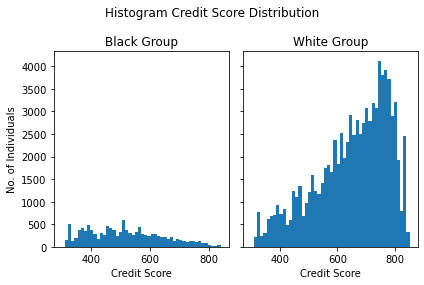

In [10]:
# make histogram of credit scores by race
visual_scores_by_race(data)

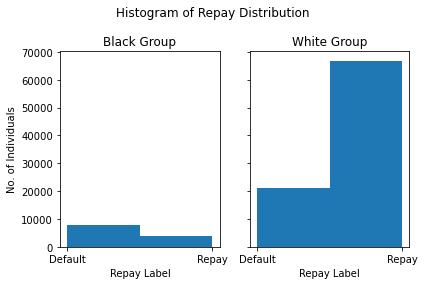

In [11]:
visual_repay_dist(data)

# 3. Classifier

In [12]:
print('The classifier trained below is: ', model_name)

results_path += f'{model_name}/'

The classifier trained below is:  lgr


In [13]:
classifier = get_classifier(model_name)

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [14]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
np.random.seed(0)

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [15]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [16]:
#adding scores to list
all_scores.extend([X_unmit_b,X_unmit_w])
scores_names.extend(['unmitB', 'unmitW'])

### Evaluation of classifier overall

In [17]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

,Unmitigated
Overall selection rate,0.7401
Demographic parity difference,0.512227
Demographic parity ratio,0.361254
------,
Overall balanced error rate,0.160758
Balanced error rate difference,0.007775
------,
True positive rate difference,0.255026
True negative rate difference,0.239476
False positive rate difference,0.239476


### Cross-validated metrics

In [18]:
x = data[['score', 'race']].values
y = data['repay_indices'].values

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print(scores)

[0.87753569 0.87572192 0.88125195 0.87682828 0.87726261]


### Delayed impact calculated
### Fairness Metric Evaluation of classifier
### Evaluation of classifier by race

In [20]:
constraint_str = 'Un-'
results_overall, results_black, results_white = evaluating_model(constraint_str,X_test,y_test, y_predict, sample_weight_test,race_test)

### Save results to dictionaries

In [21]:
run_key = f'{model_name} Unmitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33]}
{'lgr Unmitigated': [88.56, '88.56/88.17/92.68', 80.19, 67.47, 95.2, 4.8, 32.53, 38.05]}


## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [22]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [23]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [24]:
### Get new scores by race
X_egDP_b, X_egDP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [25]:
#adding scores to list
all_scores.extend([X_egDP_b, X_egDP_w])
scores_names.extend(['egdpB', 'egdpW'])

### Save results to dictionaries

In [26]:
run_key = f'{model_name} EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33], 'lgr EG DP Mitigated': [55.62, '55.62/53.94/59.24', 75.53, 35.06, 96.69, 3.31, 64.94, -38.58]}
{'lgr Unmitigated': [88.56, '88.56/88.17/92.68', 80.19, 67.47, 95.2, 4.8, 32.53, 38.05], 'lgr EG DP Mitigated': [88.64, '88.64/88.48/92.62', 77.89, 72.44, 93.74, 6.26, 27.56, 39.01]}


### Equalized Odds

In [27]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [28]:
X_egEO_b, X_egEO_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [29]:
#adding scores to list
all_scores.extend([X_egEO_b, X_egEO_w])
scores_names.extend(['egeoB', 'egeoW'])

### Save results to dictionaries

In [30]:
run_key = f'{model_name} EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33], 'lgr EG DP Mitigated': [55.62, '55.62/53.94/59.24', 75.53, 35.06, 96.69, 3.31, 64.94, -38.58], 'lgr EG EO Mitigated': [77.93, '77.93/78.55/72.55', 47.03, 73.19, 87.42, 12.58, 26.81, -5.47]}
{'lgr Unmitigated': [88.56, '88.56/88.17/92.68', 80.19, 67.47, 95.2, 4.8, 32.53, 38.05], 'lgr EG DP Mitigated': [88.64, '88.64/88.48/92.62', 77.89, 72.44, 93.74, 6.26, 27.56, 39.01], 'lgr EG EO Mitigated': [87.29, '87.29/87.32/91.63', 75.74, 74.11, 91.44, 8.56, 25.89, 38.29]}


### EOO (True Positive Rate Parity)

In [31]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [32]:
X_egEOO_b, X_egEOO_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [33]:
#adding scores to list
all_scores.extend([X_egEOO_b, X_egEOO_w])
scores_names.extend(['egeooB', 'egeooW'])

### Save results to dictionaries

In [34]:
run_key = f'{model_name} EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33], 'lgr EG DP Mitigated': [55.62, '55.62/53.94/59.24', 75.53, 35.06, 96.69, 3.31, 64.94, -38.58], 'lgr EG EO Mitigated': [77.93, '77.93/78.55/72.55', 47.03, 73.19, 87.42, 12.58, 26.81, -5.47], 'lgr EG EOO Mitigated': [74.15, '74.15/74.87/69.73', 52.03, 66.6, 89.24, 10.76, 33.4, -11.6]}
{'lgr Unmitigated': [88.56, '88.56/88.17/92.68', 80.19, 67.47, 95.2, 4.8, 32.53, 38.05], 'lgr E

### False Positive Rate Parity

In [35]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [36]:
X_egFPRP_b, X_egFPRP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [37]:
#adding scores to list
all_scores.extend([X_egFPRP_b, X_egFPRP_w])
scores_names.extend(['egfprpB', 'egfprpW'])

### Save results to dictionaries

In [38]:
run_key = f'{model_name} EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33], 'lgr EG DP Mitigated': [55.62, '55.62/53.94/59.24', 75.53, 35.06, 96.69, 3.31, 64.94, -38.58], 'lgr EG EO Mitigated': [77.93, '77.93/78.55/72.55', 47.03, 73.19, 87.42, 12.58, 26.81, -5.47], 'lgr EG EOO Mitigated': [74.15, '74.15/74.87/69.73', 52.

### Error Rate Parity

In [39]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [40]:
X_egERP_b, X_egERP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [41]:
#adding scores to list
all_scores.extend([X_egERP_b, X_egERP_w])
scores_names.extend(['egerpB', 'egerpW'])

### Save results to dictionaries

In [42]:
run_key = f'{model_name} EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 69.7, 30.3, 8.58, 8.33], 'lgr EG DP Mitigated': [55.62, '55.62/53.94/59.24', 75.53, 35.06, 96.69, 3.31, 64.94, -38.58], 'lgr EG EO Mitiga

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [44]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [45]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           0.0
             1           2.0
Name: 0, dtype: float64


The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

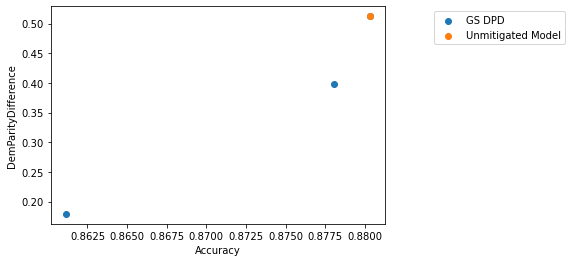

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103])),
 'GS DPD': (array([1, 1, 1, ..., 0, 0, 1]),
  array([0.98354991, 0.57470634, 0.60196188, ..., 0.35018675, 0.00845557,
         0.96858302]))}

In [46]:
grid_search_show(mitigator, demographic_parity_difference, y_predict, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [47]:
models_dict.pop('GS DPD')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

### Get new scores by race

In [48]:
X_gsDP_b, X_gsDP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [49]:
#adding scores to list
all_scores.extend([X_gsDP_b, X_gsDP_w ])
scores_names.extend(['gsdpB', 'gsdpW'])

### Save results to dictionaries

In [50]:
run_key = f'{model_name} GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36], 'lgr GS DP Mitigated': [86.11, '86.11/85.65/90.57', 76.38, 66.73, 94.07, 5.93, 33.27, '-22.37/38.8', 17.92, 16.04, 2.14, 16.04, 21.24]}
{'lgr Unmitigated': [84.18, '84.18/83.87/74.61', 28.97, 91.42, 6

### Equalized Odds Used

In [51]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [52]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=0  0           0.0
               1           0.0
      label=1  0           0.0
               1           0.0
-     label=0  0           0.0
               1           0.0
      label=1  0           0.0
               1           2.0
Name: 0, dtype: float64


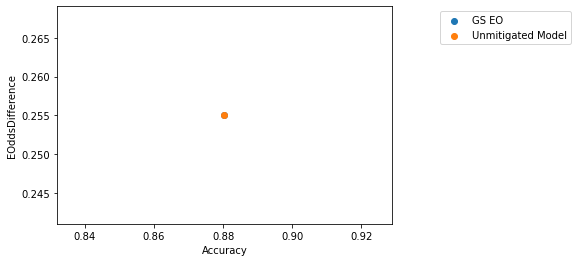

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103])),
 'GS EO': (array([1, 1, 1, ..., 0, 0, 1]),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

In [53]:
grid_search_show(mitigator, equalized_odds_difference, y_predict, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [54]:
models_dict.pop('GS EO')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

### Get new scores by race

In [55]:
X_gsEO_b, X_gsEO_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [56]:
#adding scores to list
all_scores.extend([X_gsEO_b, X_gsEO_w])
scores_names.extend(['gseoB', 'gseoW'])

### Save results to dictionaries

In [57]:
run_key = f'{model_name} GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36], 'lgr GS DP Mitigated': [86.11, '86.11/85.65/90.57', 76.38, 66.73, 94.07, 5.93, 33.27, '-22.37/38.8', 17.92, 16.04, 2.14, 16.04, 21.24], 'lgr GS EO Mitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09

### EOO (True Positive Rate Parity)

In [58]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [59]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=1  0           0.0
               1           0.0
-     label=1  0           0.0
               1           2.0
Name: 0, dtype: float64


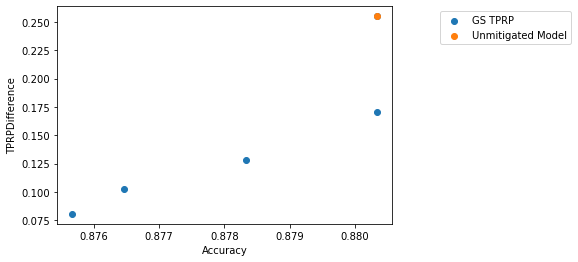

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103])),
 'GS TPRP': (array([1, 1, 1, ..., 0, 0, 1]),
  array([0.98440366, 0.5925379 , 0.61927284, ..., 0.36814866, 0.00932808,
         0.91529098]))}

In [60]:
grid_search_show(mitigator, true_positive_rate_difference, y_predict, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [61]:
models_dict.pop('GS TPRP')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

### Get new scores by race

In [62]:
X_gsEOO_b, X_gsEOO_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [63]:
#adding scores to list
all_scores.extend([X_gsEOO_b, X_gsEOO_w])
scores_names.extend(['gseooB', 'gseooW'])

### Save results to dictionaries

In [64]:
run_key = f'{model_name} GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36], 'lgr GS DP Mitigated': [86.11, '86.11/85.65/90.57', 76.38, 66.73, 94.07, 5.93, 33.27, '-22.37/38.8', 17.92, 16.04, 2.14, 16.04, 21.24], 'lgr GS EO Mitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09

### False Positive Rate Parity

In [65]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [66]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=0  0           0.0
               1           0.0
-     label=0  0           0.0
               1           2.0
Name: 0, dtype: float64


In [67]:
# NOTE: the below models are the same for DT classifier!!

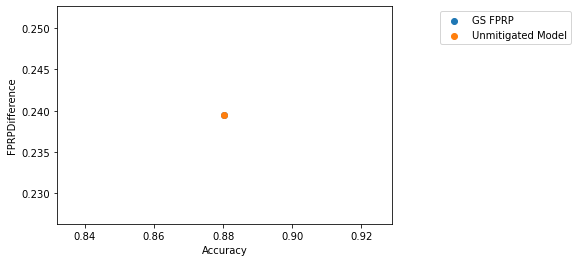

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103])),
 'GS FPRP': (array([1, 1, 1, ..., 0, 0, 1]),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

In [68]:
grid_search_show(mitigator, false_positive_rate_difference, y_predict, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [69]:
models_dict.pop('GS FPRP')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 0, 0, 1], dtype=int64),
  array([0.98671422, 0.62642342, 0.65237631, ..., 0.40067754, 0.01045687,
         0.77094103]))}

### Get scores by race

In [70]:
X_gsFPRP_b, X_gsFPRP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [71]:
#adding scores to list
all_scores.extend([X_gsFPRP_b, X_gsFPRP_w])
scores_names.extend(['gsfprpB', 'gsfprpW'])

### Save results to dictionaries

In [72]:
run_key = f'{model_name} GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36], 'lgr GS DP Mitigated': [86.11, '86.11/85.65/90.57', 76.38, 66.73, 94.07, 5.93, 33.27, '-22.37/38.8', 17.92, 16.04, 2.14, 16.04, 21.24], 'lgr GS EO Mitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09

### Error Rate Parity

In [73]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [74]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           0.0
             1           2.0
Name: 0, dtype: float64


In [75]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Get scores by race

In [76]:
X_gsERP_b, X_gsERP_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [77]:
#adding scores to list
all_scores.extend([X_gsERP_b, X_gsERP_w])
scores_names.extend(['gserpB', 'gserpW'])

### Save results to dictionaries

In [78]:
run_key = f'{model_name} GS ERP Mitigated'
print(run_key)
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

lgr GS ERP Mitigated
{'lgr Unmitigated': [88.03, '88.03/87.82/91.74', 74.01, 74.09, 93.76, 6.24, 25.91, '8.33/38.05', 51.22, 25.5, 25.5, 23.95, 4.39], 'lgr EG DP Mitigated': [84.66, '84.66/84.0/89.67', 77.61, 62.11, 93.91, 6.09, 37.89, '-38.58/39.01', 2.36, 37.38, 2.94, 37.38, 33.02], 'lgr EG EO Mitigated': [86.16, '86.16/86.06/90.33', 72.28, 73.85, 91.21, 8.79, 26.15, '-5.47/38.29', 28.71, 4.02, 4.02, 0.92, 9.35], 'lgr EG EOO Mitigated': [86.69, '86.69/86.44/90.83', 74.22, 71.42, 92.96, 7.04, 28.58, '-11.6/38.98', 25.24, 6.67, 3.95, 6.67, 14.26], 'lgr EG FPRP Mitigated': [87.35, '87.35/87.09/91.3', 74.5, 72.09, 93.62, 6.38, 27.91, '-4.95/38.8', 31.68, 6.66, 6.66, 2.26, 10.34], 'lgr EG ERP Mitigated': [85.37, '85.37/85.4/89.65', 70.49, 75.56, 89.4, 10.6, 24.44, '8.33/36.15', 47.22, 21.92, 20.88, 21.92, 1.36], 'lgr GS DP Mitigated': [86.11, '86.11/85.65/90.57', 76.38, 66.73, 94.07, 5.93, 33.27, '-22.37/38.8', 17.92, 16.04, 2.14, 16.04, 21.24], 'lgr GS EO Mitigated': [88.03, '88.03/87.82

# 4. Save results to csv files

In [81]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB','DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_in_csv(overall_results_dict, overall_fieldnames,  results_path+model_name+'_overall_results.csv')
    save_dict_in_csv(black_results_dict, byrace_fieldnames,  results_path+model_name+'_black_results.csv')
    save_dict_in_csv(white_results_dict, byrace_fieldnames,  results_path+model_name+'_white_results.csv')

In [82]:
if save == True:
    # Save overall score results
    columns_data = zip_longest(*all_scores)

    with open(results_path+model_name+'_overall_scores.csv',mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(scores_names)
        writer.writerows(columns_data)
        f.close()